In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
data_path = './data/lsapp.tsv.gz'
df = pd.read_csv(data_path, sep='\t')

df.loc[:,'timestamp'] = pd.to_datetime(df['timestamp'])
df = df.rename(columns={'lsapp.tsv': 'user_id'})

df_open = df.loc[df['event_type'] == 'Opened']

In [3]:
df_open.head()

,user_id,session_id,timestamp,app_name,event_type
0,0.0,1.0,2018-01-16 06:01:05,Minesweeper Classic (Mines),Opened
2,0.0,1.0,2018-01-16 06:01:07,Minesweeper Classic (Mines),Opened
4,0.0,1.0,2018-01-16 06:01:08,Minesweeper Classic (Mines),Opened
6,0.0,1.0,2018-01-16 06:01:08,Minesweeper Classic (Mines),Opened
8,0.0,1.0,2018-01-16 06:01:09,Minesweeper Classic (Mines),Opened


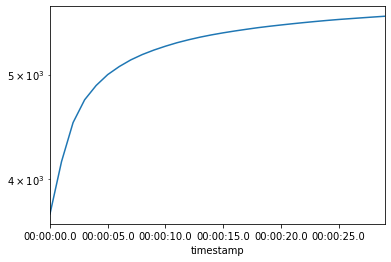

In [4]:
df_sorted = df_open.sort_values('timestamp')
(
    df_sorted
    .timestamp
    .diff()
    .groupby(df_sorted.user_id)
    .value_counts()
    .reset_index(level=0, drop=True)
    .sort_index()
    .groupby(level=0, sort=True)
    .mean()
    .cumsum()
    .iloc[:30]
    .plot(logy=True)
);

In [5]:
df.head()

,user_id,session_id,timestamp,app_name,event_type
0,0.0,1.0,2018-01-16 06:01:05,Minesweeper Classic (Mines),Opened
1,0.0,1.0,2018-01-16 06:01:05,Minesweeper Classic (Mines),Closed
2,0.0,1.0,2018-01-16 06:01:07,Minesweeper Classic (Mines),Opened
3,0.0,1.0,2018-01-16 06:01:07,Minesweeper Classic (Mines),Closed
4,0.0,1.0,2018-01-16 06:01:08,Minesweeper Classic (Mines),Opened


In [6]:
df.event_type.unique()

array(['Opened', 'Closed', 'User Interaction', 'Broken', nan],
      dtype=object)

In [7]:
df.shape, df_open.shape

((3658590, 5), (1673261, 5))

## Prepare for DataProcessor:

In [8]:
df_open = df_open.dropna()

In [9]:
uniq_apps = list(df_open["app_name"].unique())
app2id = dict(zip(uniq_apps, range(len(uniq_apps))))

In [10]:
df_open["appid"] = df_open["app_name"].apply(lambda x: app2id[x])

In [11]:
df_open["userid"] = df_open["user_id"].astype(int)

In [12]:
out = df_open[["userid", "appid", "timestamp", "app_name"]]
out.head()

,userid,appid,timestamp,app_name
0,0,0,2018-01-16 06:01:05,Minesweeper Classic (Mines)
2,0,0,2018-01-16 06:01:07,Minesweeper Classic (Mines)
4,0,0,2018-01-16 06:01:08,Minesweeper Classic (Mines)
6,0,0,2018-01-16 06:01:08,Minesweeper Classic (Mines)
8,0,0,2018-01-16 06:01:09,Minesweeper Classic (Mines)


In [13]:
out.timestamp = out.timestamp.apply(lambda x: '{:%Y%m%d%H%M%S}'.format(datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')))

/home/albert/.local/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
out = out.reset_index(drop=True)
out.head()

,userid,appid,timestamp,app_name
0,0,0,20180116060105,Minesweeper Classic (Mines)
1,0,0,20180116060107,Minesweeper Classic (Mines)
2,0,0,20180116060108,Minesweeper Classic (Mines)
3,0,0,20180116060108,Minesweeper Classic (Mines)
4,0,0,20180116060109,Minesweeper Classic (Mines)


In [15]:
out.to_csv("./data/lsapp.csv", index=False, sep=' ', header=False)

# Look at DataProcessor:

In [16]:
from DataProcessor import DataProcessor
from dataprep import list_session_lists

## Do not drop consecutive sessions:

In [17]:
process_data = DataProcessor(
    "./data/lsapp.csv",
    column_names='userid,appid,timestamp,app_name',
    session_break_delta='15min',
)

In [18]:
data = process_data.read_data()
data.head()

,userid,appid,timestamp,app_name
0,0,0,2018-01-16 06:01:05,Minesweeper Classic (Mines)
1,0,0,2018-01-16 06:01:07,Minesweeper Classic (Mines)
2,0,0,2018-01-16 06:01:08,Minesweeper Classic (Mines)
3,0,0,2018-01-16 06:01:08,Minesweeper Classic (Mines)
4,0,0,2018-01-16 06:01:09,Minesweeper Classic (Mines)


In [19]:
data = process_data.create_sessid_column(data)
data.head()

,userid,appid,timestamp,app_name,sessid,sessid_global
0,0,0,2018-01-16 06:01:05,Minesweeper Classic (Mines),0,0
1,0,0,2018-01-16 06:01:07,Minesweeper Classic (Mines),0,0
2,0,0,2018-01-16 06:01:08,Minesweeper Classic (Mines),0,0
3,0,0,2018-01-16 06:01:08,Minesweeper Classic (Mines),0,0
4,0,0,2018-01-16 06:01:09,Minesweeper Classic (Mines),0,0


In [20]:
data.groupby(["userid", "sessid"]).size().describe()

count    31799.000000
mean        52.619925
std        179.575103
min          1.000000
25%          4.000000
50%         12.000000
75%         38.000000
max       9855.000000
dtype: float64

In [21]:
denom = data.groupby(["userid", "sessid"]).size().value_counts().sum()
freq_map = (data.groupby(["userid", "sessid"]).size().value_counts() / denom)

In [22]:
prob = data.groupby(["userid", "sessid"]).apply(lambda x: freq_map[x.shape[0]]).values.tolist()

In [23]:
inds = data.groupby(["userid", "sessid"]).apply(lambda x: freq_map[x.shape[0]]).index.tolist()

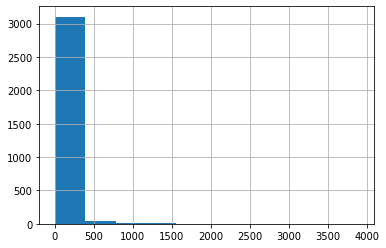

In [24]:
pd.Series(np.random.choice(freq_map.index, int(0.1 * len(inds)), p=freq_map.values)).hist();

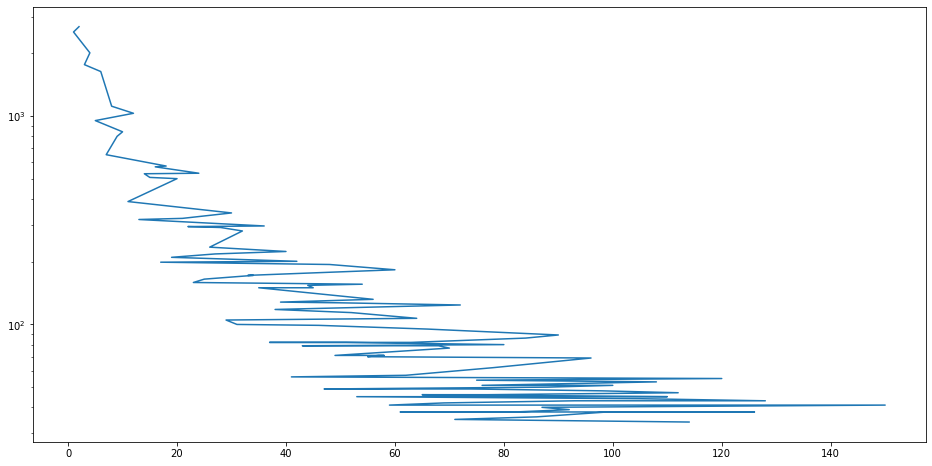

In [25]:
(
    data
    .groupby(["userid", "sessid"])
    .size()
    .value_counts()
    .sort_values(ascending=False)
    .iloc[:100]
    .plot(logy=True, figsize=(16, 8))
);

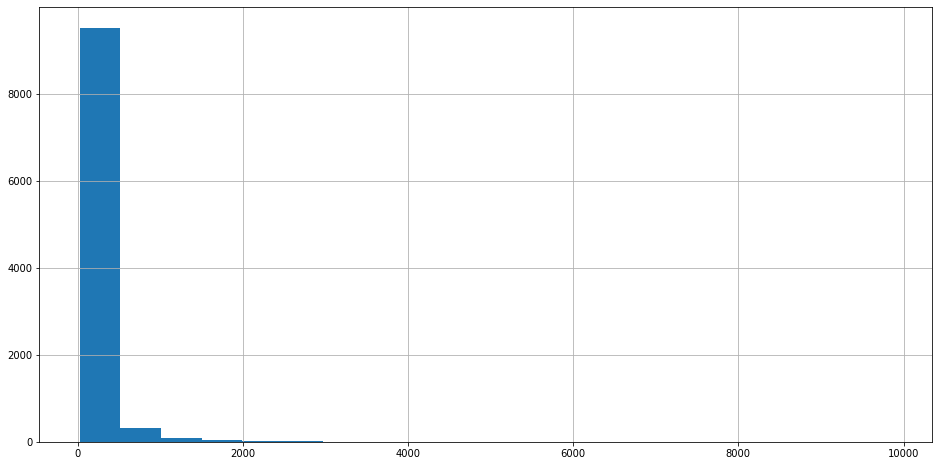

In [26]:
(
    data
    .groupby(["userid", "sessid"])
    .size()
    .sort_values(ascending=False)
    .iloc[:10000]
    .hist(figsize=(16, 8), bins=20)
);

In [27]:
train, valid, test = process_data.train_valid_test(data, reindex=True, test_interval="14d", valid_interval="7d")

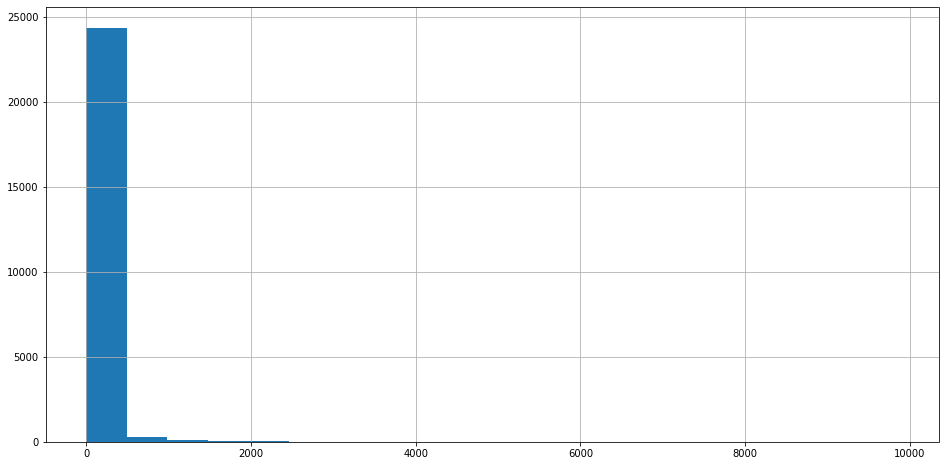

In [28]:
(
    train
    .groupby(["userid", "sessid"])
    .size()
    .sort_values(ascending=False)
    #.iloc[:10000]
    .hist(figsize=(16, 8), bins=20)
);

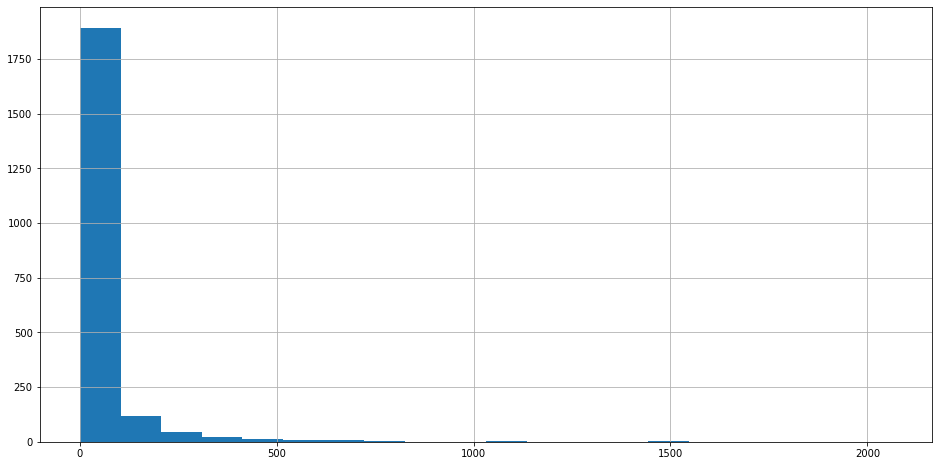

In [29]:
(
    valid
    .groupby(["userid", "sessid"])
    .size()
    .sort_values(ascending=False)
    #.iloc[:10000]
    .hist(figsize=(16, 8), bins=20)
);

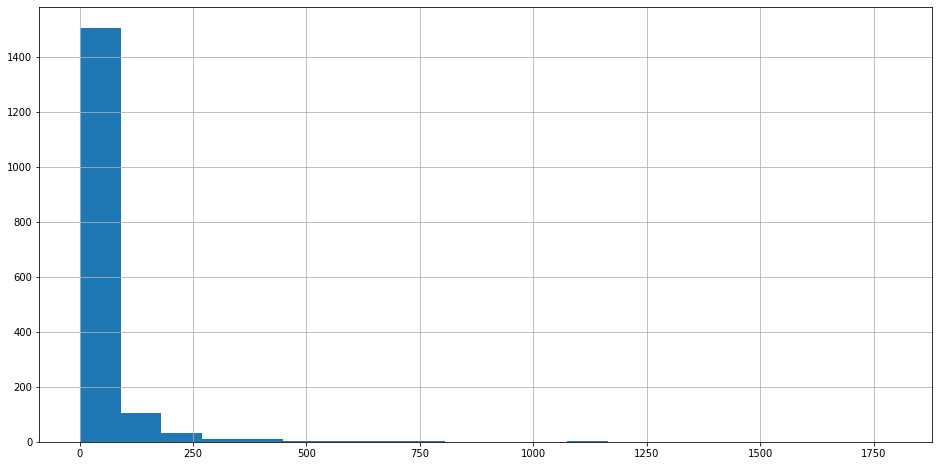

In [30]:
(
    test
    .groupby(["userid", "sessid"])
    .size()
    .sort_values(ascending=False)
    #.iloc[:10000]
    .hist(figsize=(16, 8), bins=20)
);